In [1]:
import gwpy
from gwpy.timeseries import TimeSeries
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
fn = 'data/L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5'

In [3]:
data = TimeSeries.read(fn,format='hdf5.losc')
asd = data.asd()
fs = 4096

#data = data.whiten()
data = data.whiten()
data = data.bandpass(30, 1000)

def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)
    
indx = slice(int((1842-16)*fs), int((1842+16)*fs)) #-- For cleaned data, grab 32 seconds around trig time
strain = data[indx]

# -- Make .wav files, seconds
audio_fn = 'test' + '-' + 'gwpy' + '-data'+'.wav'
audio_fn = os.path.join('wav', audio_fn)
write_wavfile(audio_fn,4096,strain)

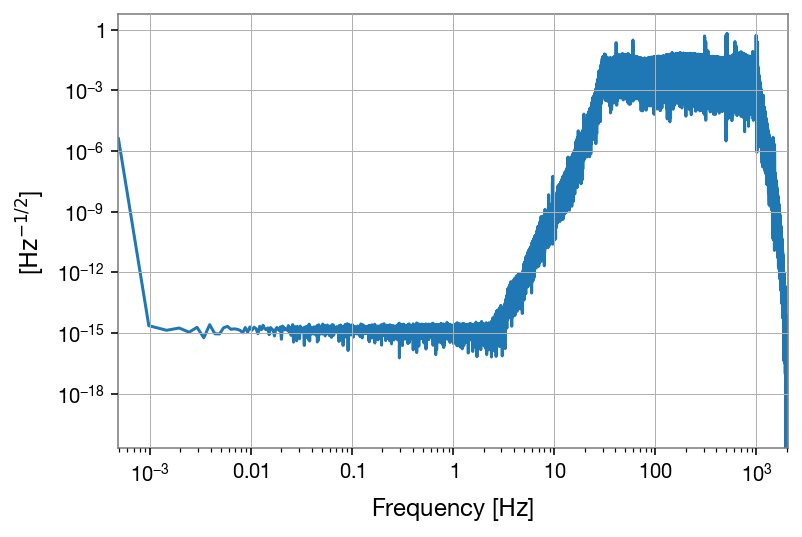

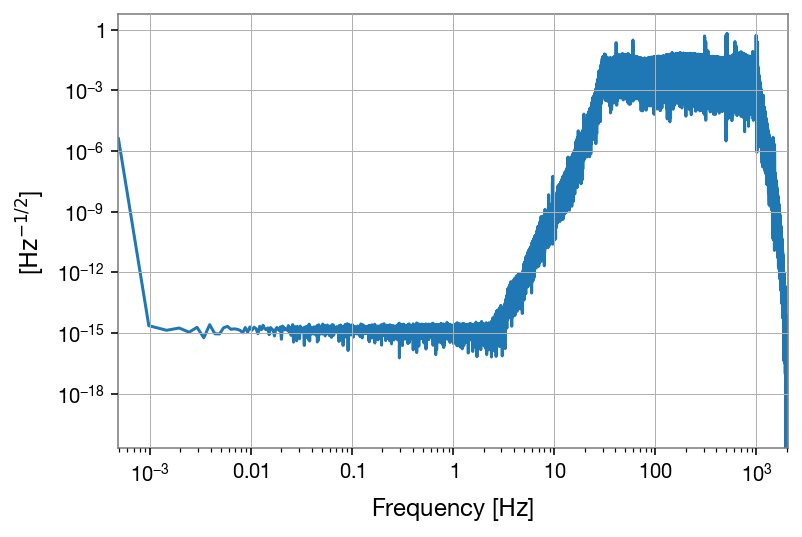

In [4]:
data.asd().plot()

TimeSeries([-6.83991664e-24, -6.74767945e-24, -6.57770632e-24,
            ..., -6.37885944e-23,  3.72450081e-23,
            -1.60863671e-25]
           unit: dimensionless,
           t0: -5.697509766 s,
           dt: 0.000244140625 s,
           name: None,
           channel: None)


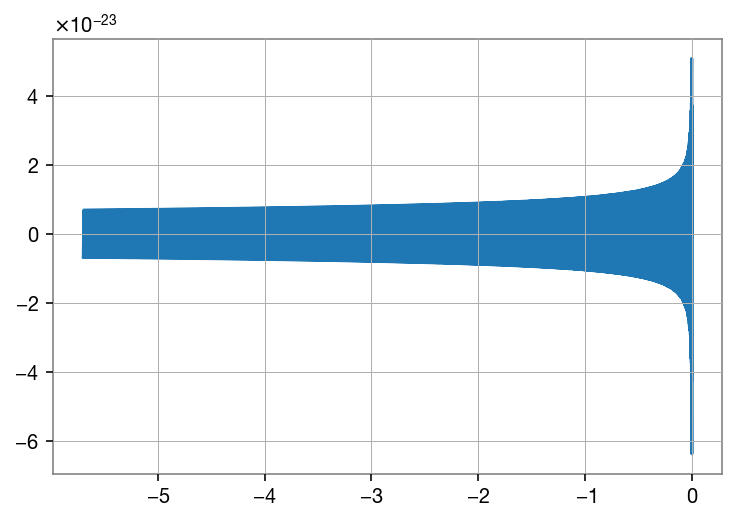

In [6]:
from pycbc.waveform import get_td_waveform

#apx = 'SEOBNRv2'
apx = 'SpinTaylorT2'
m1 = 1.4
m2 = 1.4
spin = 0
distance = 400
flow = 70

hp, hc = get_td_waveform(approximant=apx,
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=spin,
                                 delta_t=1.0/fs,
                                 distance = distance,
                                 f_lower=flow)
plt.figure()
plt.plot(hp.sample_times, hp)
template = TimeSeries(hp)
template.dt = 1.0/fs
template.t0 = hp.sample_times[0]
print(template)

# taper: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.taper
# pad: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html?highlight=pad#gwpy.timeseries.TimeSeries.pad

TimeSeries([-0.00000000e+00, -1.20778095e-48, -4.71345650e-36,
            ..., -5.21519267e-23,  6.79444010e-24,
            -0.00000000e+00]
           unit: dimensionless,
           t0: -5.697509766 s,
           dt: 0.000244140625 s,
           name: None,
           channel: None)
131072
131072
TimeSeries([0., 0., 0., ..., 0., 0., 0.]
           unit: dimensionless,
           t0: -15.99975585975 s,
           dt: 0.000244140625 s,
           name: None,
           channel: None)


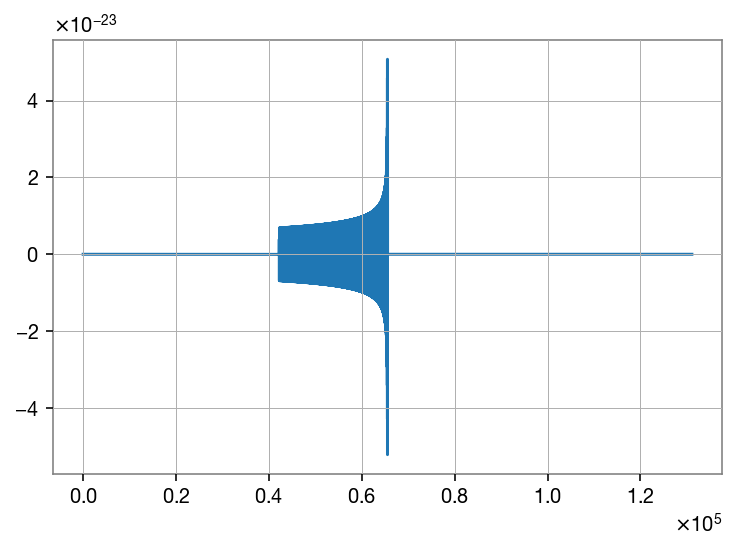

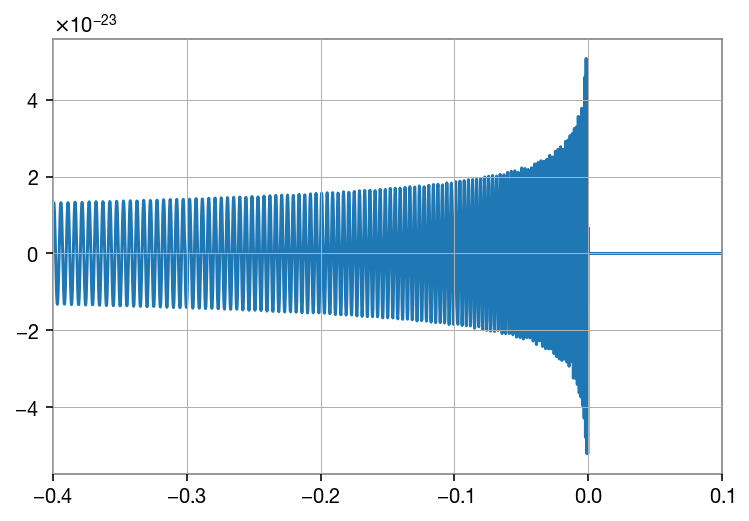

In [7]:
tapered = template.taper()
print(tapered)
padded = tapered.pad( (fs*16-len(template), fs*16))
print(len(padded.times))
padded.times=None
print(len(padded))
plt.figure()
plt.plot(padded.value)
plt.figure()
plt.plot(padded)
plt.xlim(-0.4,0.1)
print(padded)

In [8]:
## various whitening methods
def hack_whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht


from scipy.interpolate import interp1d
psd = interp1d(asd.frequencies, asd**2)


white_template = hack_whiten(padded, psd, 1.0/4096)
plt.plot(padded.times,white_template)
plt.xlim(-4.1, -3.9)
plt.ylim(-1,1)


def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)
    

write_wavfile('test_audio.wav', fs, white_template)